# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation

#from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import os 
import re
#from sklearn import cross_validation
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score

from pandas import DataFrame
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,auc

from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV

In [5]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 limit 100000
""", con) 

def partition(x):
    if x < 3:
        return 0
    return 1


actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [13]:
final_pos=final[final.Score==1]
final_neg=final[final.Score==0]


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'ma', 'hers', 'here', 'same', 'now', 'only', 'such', 'if', 'or', 'any', 'had', 'you', 'themselves', "you'd", 'them', 'there', 'out', 'myself', 've', 'an', "needn't", 'off', "weren't", 'his', 'against', 'than', 'the', 'below', 'up', "isn't", 'needn', 'of', "mustn't", "couldn't", 'hadn', 'll', 'nor', 'doing', 'ain', 'didn', 'he', 'from', 'our', 'above', "wasn't", 'weren', 'its', 'can', 'all', "she's", 'no', 'hasn', 'because', 'him', 'who', 'so', 'during', 'after', 't', 'isn', 'theirs', 'into', 'don', 'haven', 'both', "haven't", 'other', 'ours', "mightn't", "won't", 'each', 'won', "you're", 'y', 'between', 'yourselves', 'about', 'on', 'shan', 'yourself', 'they', 'couldn', 'which', 'was', 'their', 'at', 's', 'and', 'should', "that'll", 'that', 'over', 'where', 'mightn', 'shouldn', 'mustn', 'these', 'be', 'for', 'to', 'by', 'not', 'down', 'before', 'i', 'm', 'we', 'wouldn', 'aren', "aren't", 'very', 'whom', 'being', 'having', 'what', 'will', 'a', 'd', 'yours', "it's", 'my', "wouldn't", 'ha

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] ==0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:28<00:00, 3062.77it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [23]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
count_vect_bow = CountVectorizer() #in scikit-learn
count_vect_bow.fit_transform(preprocessed_reviews)
print("some feature names ", count_vect_bow.get_feature_names()[:10])
print('='*50)

final_counts = count_vect_bow.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [26]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [28]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7867549657821655), ('awesome', 0.7750175595283508), ('excellent', 0.7727563977241516), ('terrific', 0.7481140494346619), ('good', 0.7371719479560852), ('wonderful', 0.7310999631881714), ('amazing', 0.6406309604644775), ('fabulous', 0.6146283745765686), ('nice', 0.6130000352859497), ('perfect', 0.5992628335952759)]
[('greatest', 0.81913822889328), ('nastiest', 0.7118346095085144), ('best', 0.7105083465576172), ('tastiest', 0.6735264658927917), ('disgusting', 0.6169978380203247), ('smoothest', 0.6004220843315125), ('coolest', 0.5986064076423645), ('horrible', 0.5918089747428894), ('hottest', 0.5901439785957336), ('nicest', 0.5877628326416016)]


number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

  0%|          | 0/87773 [00:00<?, ?it/s]


NameError: name 'w2v_words' is not defined

#### [4.4.1.2] TFIDF weighted W2v

In [470]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [318]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [28:00<00:00, 52.23it/s] 


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [319]:
# Please write all the code with proper documentation
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)


In [320]:
from sklearn import cross_validation
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

Applied BOW on Test Train & CV Separately

In [321]:
bow_X_tr=count_vect.fit_transform(X_tr)
bow_X_cv=count_vect.transform(X_cv)
bow_X_test=count_vect.transform(X_test)

In [322]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc' ,cv=3)
model.fit(bow_X_tr, y_tr)


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [323]:
print(model.best_estimator_)
print(model.score(bow_X_tr, y_tr))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9888752923304983


In [324]:
clf=LogisticRegression(C=1,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 3270


In [ ]:
# from sklearn import metrics

predictions_bow_test=clf.predict(bow_X_test)
predictions_bow_train=clf.predict(bow_X_tr)
predict_bow_test=clf.predict_proba(bow_X_test)
predict_train_bow=clf.predict_proba(bow_X_tr)

predictions_bow_cv=clf.predict(bow_X_cv)
predict_bow_cv=clf.predict_proba(bow_X_cv)



preds = clf.predict_proba(bow_X_tr)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_tr, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))



In [326]:
predict_train_bow.shape
y_tr.shape

(43008,)

#### Confusion Matrix Test Data Set

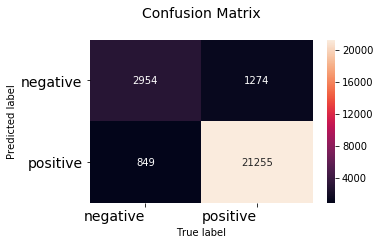

In [327]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_bow_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

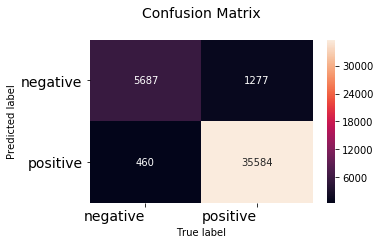

In [328]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_bow_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

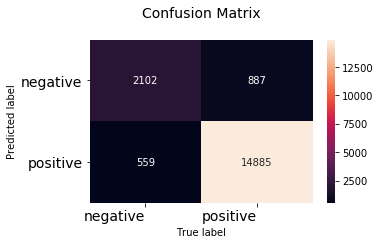

In [329]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_bow_cv), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

sparsity on weight vector: 3270


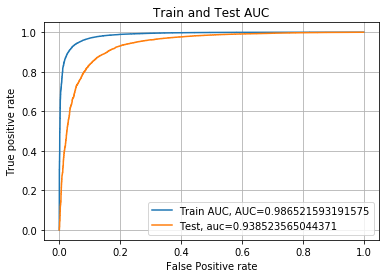

In [330]:
#predictions_bow_cv=clf.predict(bow_X_cv)
#predict_bow_cv=clf.predict_proba(bow_X_cv)

fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_train_bow[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_bow_train = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_bow_test[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_bow_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_bow_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_bow_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show
#print("AUC for BOW L1 " , auc_bow)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [331]:
# Please write all the code with proper documentation
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

sparsity on weight vector: 3270


In [332]:
clf=LogisticRegression(C=10,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 4677


In [333]:
clf=LogisticRegression(C=100,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 4966


In [334]:
clf=LogisticRegression(C=1000,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 4999


In [335]:
clf=LogisticRegression(C=.1,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 731


In [336]:
clf=LogisticRegression(C=.01,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 93


In [337]:
clf=LogisticRegression(C=.001,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

sparsity on weight vector: 4


/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


In [338]:
clf=LogisticRegression(C=1,  dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(bow_X_tr, y_tr)
print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


sparsity on weight vector: 3270


In [339]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [340]:
# Please write all the code with proper documentation
clf_l2=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_l2.fit(bow_X_tr, y_tr)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [341]:
predictions_bow_test_l2=clf_l2.predict(bow_X_test)
predictions_bow_train_l2=clf_l2.predict(bow_X_tr)
predict_bow_test_l2=clf_l2.predict_proba(bow_X_test)
predict_bow_train_l2=clf_l2.predict_proba(bow_X_tr)

predictions_bow_cv_l2=clf_l2.predict(bow_X_cv)
predict_bow_cv_l2=clf_l2.predict_proba(bow_X_cv)

#### Confusion Matrix Test Data Set

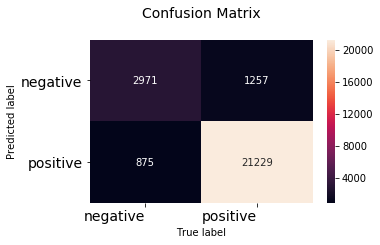

In [342]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_bow_test_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

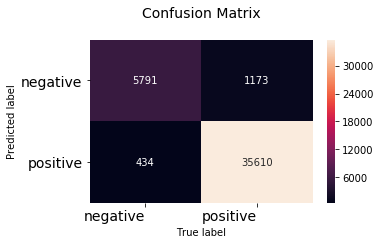

In [343]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_bow_train_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

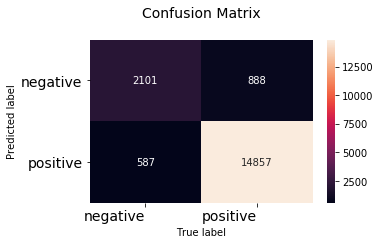

In [344]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_bow_cv_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

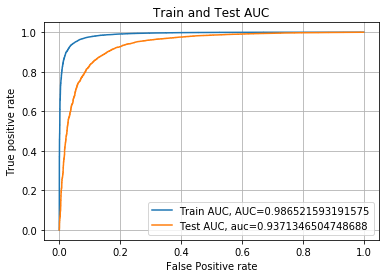

In [345]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_bow_train_l2[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_bow_train_l2 = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_bow_test_l2[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_bow_test_l2 = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_bow_train_l2))
plt.plot(fpr2,tpr2,label="Test AUC, auc="+str(auc_bow_test_l2))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [346]:
# Please write all the code with proper documentation

In [347]:
clf_bow_perb = LogisticRegression(C= 10, penalty= 'l2',n_jobs=4)
clf_bow_perb.fit(bow_X_tr, y_tr)
y_pred_perb = clf_bow_perb.predict(bow_X_tr)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_tr, y_pred_perb)*100))
print("Non Zero weights:",np.count_nonzero(clf_bow_perb.coef_))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


Accuracy on test set: 96.884%
Non Zero weights: 5000


In [348]:
from scipy.sparse import find
#Weights before adding random noise
## True Weights
weights1 = find(clf_bow_perb.coef_[0])[2]
#print(weights1[:50])

In [349]:
from scipy.sparse import find
X_train_n = bow_X_tr
#Random noise
epsilon = np.random.uniform(low=-0.000001, size=(find(X_train_n)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(bow_X_tr)

#Introducing random noise to non-zero datapoints
X_train_n[a,b] = epsilon + X_train_n[a,b]

In [350]:
clf_bow_noise = LogisticRegression(C= 1000, penalty= 'l2')
clf_bow_noise.fit(X_train_n,y_tr)
y_pred = clf_bow_noise.predict(bow_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf_bow_noise.coef_))

Accuracy on test set: 91.482%
Non Zero weights: 5000


In [351]:
##perturb_weights
weights2 = find(clf_bow_noise.coef_[0])[2]
print(weights2.size)

5000


In [352]:
weights_diff = ((weights1 - weights2)/weights1)*100

In [353]:
weights_diff_f1 = weights1 - weights2
weights_diff_sort=np.argsort(np.absolute(weights_diff_f1) )


In [354]:
#weights_diff_sort=np.sort(np.absolute(weights_diff))
#weights_diff_f12=weights_diff_f1[weights_diff_f1>1]

In [355]:
weights_diff_f12 = weights_diff_f1[(weights_diff_f1 >= 1.5)]
#weights_diff_f12

Based on the given Results  there are no values which have threshold greater than 1.5

In [356]:
#absolute_weights0 = np.absolute(weights1)
sorted_absolute_index = np.sort(weights_diff_sort)
sorted_absolute_index[::-1][:10]

array([4999, 4998, 4997, 4996, 4995, 4994, 4993, 4992, 4991, 4990])

In [357]:
top_index = weights_diff_sort[::-1][:20]

In [358]:
feature_data=pd.DataFrame(list(weights1.T),columns=['true_weights'])

In [359]:
features=(count_vect.get_feature_names())
feature_data['Feature_name']=features

In [360]:
feature_data['perturb_weights']=list(weights2.T)
feature_data['%change']=((feature_data['true_weights']-feature_data['perturb_weights'])/feature_data['true_weights'])*100

#### Change in Weights Post Pertubation

In [361]:
feature_data.head()

,true_weights,Feature_name,perturb_weights,%change
0,-1.228488,ability,-1.200327,2.292266
1,0.355219,able,0.356636,-0.399167
2,-0.871347,able buy,-0.836732,3.972564
3,0.707287,able find,0.688386,2.672302
4,1.249190,able get,1.249878,-0.055058


In [362]:
from scipy import stats

In [363]:
for i in range(11):
    #print(i)
    j=(99)+(i*.1)
    #print(j)
    
    percentil1_w2=stats.scoreatpercentile(weights2, [j])
    print("Percentile Values for ",j , percentil1_w2)

Percentile Values for  99.0 [2.36682753]
Percentile Values for  99.1 [2.41855588]
Percentile Values for  99.2 [2.50323965]
Percentile Values for  99.3 [2.57119152]
Percentile Values for  99.4 [2.62078659]
Percentile Values for  99.5 [2.70166512]
Percentile Values for  99.6 [2.7654889]
Percentile Values for  99.7 [2.87204999]
Percentile Values for  99.8 [2.97036334]
Percentile Values for  99.9 [3.12309222]
Percentile Values for  100.0 [5.25385208]


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [364]:
coef =clf.coef_.ravel()
top_positives = np.argsort(coef)[-10:]
top_negatives = np.argsort(coef)[:10]

In [365]:
top_positives 
feature_names = np.array(features)

In [366]:
feature_names[top_positives]

array(['bad thing', 'amazon price', 'four stars', 'right amount', 'whim',
       'really well', 'not overpowering', 'pleasantly', 'no bitterness',
       'not disappointed'], dtype='<U21')

In [367]:
top_positive_features=pd.DataFrame(list(top_positives.T),columns=['true_'])
top_positive_features['Positive Feature_names']=feature_names[top_positives]

In [368]:
top_positive_features

,true_,Positive Feature_names
0,248,bad thing
1,136,amazon price
2,1628,four stars
3,3702,right amount
4,4836,whim
5,3586,really well
6,2954,not overpowering
7,3302,pleasantly
8,2828,no bitterness
9,2888,not disappointed


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [369]:
# Please write all the code with proper documentation

In [370]:
top_negatives_features=pd.DataFrame(list(top_negatives.T),columns=['true_'])
top_negatives_features['Negative Feature_name']=feature_names[top_negatives]

In [371]:
top_negatives_features

,true_,Negative Feature_name
0,3002,not worth
1,4909,worst
2,2928,not impressed
3,2965,not recommend
4,4064,sounded
5,1134,disappointing
6,921,could easily
7,2879,not buying
8,3710,rip
9,1135,disappointment


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [372]:
# Please write all the code with proper documentation

labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)

In [373]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

Applied TFIDF on Test Train & CV Separately

In [374]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
tf_X_tr=tf_idf_vect.fit_transform(X_tr)
tf_X_cv=tf_idf_vect.transform(X_cv)
tf_X_test=tf_idf_vect.transform(X_test)

In [375]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=3)
model.fit(tf_X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [376]:
print(model.best_estimator_)
print(model.score(tf_X_tr, y_tr))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9695954891364404


In [380]:
clf_tf_l1=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_tf_l1.fit(tf_X_tr, y_tr)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [381]:
predictions_tf_test=clf_tf_l1.predict(tf_X_test)
predictions_tf_train=clf_tf_l1.predict(tf_X_tr)
predict_tf_test=clf_tf_l1.predict_proba(tf_X_test)
predict_tf_train=clf_tf_l1.predict_proba(tf_X_tr)

predictions_tf_cv=clf_tf_l1.predict(tf_X_cv)
predict_tf_cv=clf_tf_l1.predict_proba(tf_X_cv)

#### Confusion Matrix Test Data Set

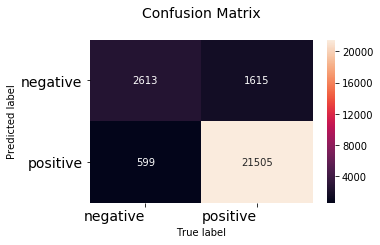

In [382]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_tf_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

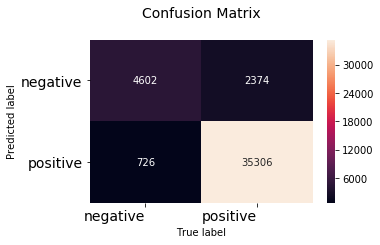

In [383]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_tf_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

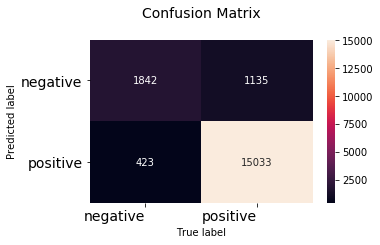

In [384]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_tf_cv), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

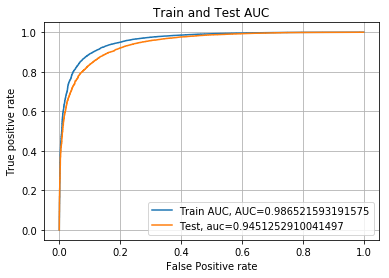

In [385]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_tf_train[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_tf_train = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tf_test[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_tf_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_tf_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_tf_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show
#print("AUC for BOW L1 " , auc_bow)
#print("sparsity on weight vector:",np.count_nonzero(clf.coef_))

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [386]:
# Please write all the code with proper documentation

clf_tf_l2=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_tf_l2.fit(tf_X_tr, y_tr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [387]:
predictions_tf2_test=clf_tf_l2.predict(tf_X_test)
predictions_tf2_train=clf_tf_l2.predict(tf_X_tr)
predict_tf2_test=clf_tf_l2.predict_proba(tf_X_test)
predict_tf2_train=clf_tf_l2.predict_proba(tf_X_tr)

predictions_tf2_cv=clf_tf_l2.predict(tf_X_cv)
predict_tf2_cv=clf_tf_l2.predict_proba(tf_X_cv)

#### Confusion Matrix Test Data Set

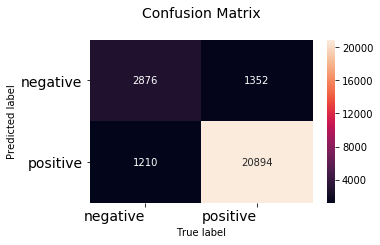

In [388]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_tf2_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

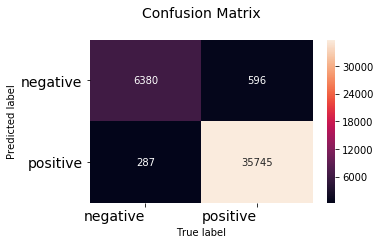

In [389]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_tf2_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

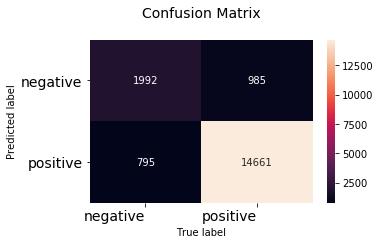

In [390]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_tf2_cv), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

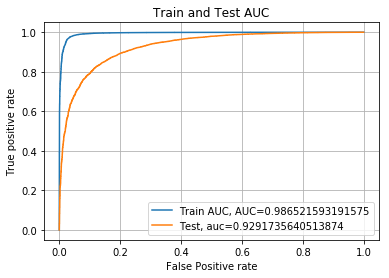

In [391]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_tf2_train[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_tf_train_l2 = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tf2_test[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_tf_test_l2 = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_tf_train_l2))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_tf_test_l2))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [392]:
# Please write all the code with proper documentation



In [393]:
coef_tf =clf_tf_l1.coef_.ravel()
top_positives_tf = np.argsort(coef_tf)[-10:]
top_negatives_tf = np.argsort(coef_tf)[:10]

In [394]:
features_tf=(tf_idf_vect.get_feature_names())
feature_names_tf = np.array(features_tf)

In [395]:
feature_names_tf[top_positives_tf]

array(['loves', 'awesome', 'amazing', 'hooked', 'wonderful', 'excellent',
       'best', 'perfect', 'delicious', 'great'], dtype='<U16')

In [403]:
top_positvies_features_tf=pd.DataFrame(list(top_positives_tf.T),columns=['true_'])
top_positvies_features_tf['Positive Feature_name TFIDF']=feature_names_tf[top_positive_features_tf]

In [405]:
top_positvies_features_tf

,true_,Positive Feature_name TFIDF
0,4175,loves
1,433,awesome
2,214,amazing
3,3407,hooked
4,8018,wonderful
5,2459,excellent
6,596,best
7,5153,perfect
8,1862,delicious
9,3130,great


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [406]:
# Please write all the code with proper documentation


In [407]:
feature_names_tf[top_negatives_tf]

array(['worst', 'disappointing', 'awful', 'terrible', 'disappointment',
       'not', 'horrible', 'unfortunately', 'poor', 'disappointed'],
      dtype='<U16')

In [408]:
top_negatives_features_tf=pd.DataFrame(list(top_negatives_tf.T),columns=['true_'])
top_negatives_features_tf['Negative Feature_name TFIDF']=feature_names_tf[top_negatives_tf]
top_negatives_features_tf

,true_,Negative Feature_name TFIDF
0,8049,worst
1,2027,disappointing
2,434,awful
3,7266,terrible
4,2028,disappointment
5,4752,not
6,3418,horrible
7,7634,unfortunately
8,5333,poor
9,2026,disappointed


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [409]:
# Please write all the code with proper documentation



In [36]:
from sklearn.model_selection import cross_validate as cross_validation

In [37]:
from sklearn.model_selection import train_test_split


In [30]:
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)

In [ ]:
X_train,X_test, y_train, y_test= train_test_split(df_data['clean_text'],labels,test_size=.2,random_state=123,stratify=labels)


In [41]:
X_train, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_1, test_size=0.3)

Converted Test Train & CV Data to AVG Word to Vec

In [42]:
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())  

i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())    



In [44]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8201406002044678), ('excellent', 0.774410605430603), ('awesome', 0.7615398168563843), ('terrific', 0.756493091583252), ('good', 0.7372565269470215), ('wonderful', 0.7172281742095947), ('amazing', 0.6674115061759949), ('fabulous', 0.6346491575241089), ('perfect', 0.6181733012199402), ('decent', 0.5980851054191589)]
[('greatest', 0.7932060956954956), ('best', 0.6901300549507141), ('tastiest', 0.6855100989341736), ('nastiest', 0.6615065932273865), ('smoothest', 0.6217610836029053), ('disgusting', 0.597895085811615), ('horrible', 0.5833701491355896), ('softest', 0.5697371959686279), ('awful', 0.560451865196228), ('healthiest', 0.5577352643013)]


In [46]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['not', 'like', 'good', 'one', 'great', 'taste', 'would', 'coffee', 'product', 'flavor', 'tea', 'love', 'food', 'no', 'get', 'really', 'amazon', 'much', 'also', 'time', 'use', 'little', 'best', 'price', 'buy', 'tried', 'even', 'make', 'well', 'find', 'dog', 'chocolate', 'better', 'try', 'eat', 'first', 'sugar', 'cup', 'could', 'drink', 'bag', 'water', 'found', 'used', 'made', 'sweet', 'bought', 'free', 'two', 'way']


In [67]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vecc",vec.shape)
            #print("veccddd",sent_vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 43008/43008 [00:48<00:00, 889.92it/s] 

43008
100


In [68]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 26332/26332 [00:30<00:00, 862.29it/s] 

26332
100


In [69]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

  0%|          | 0/18433 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (50,) (100,) (50,) 

In [418]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=3)
model.fit(sent_vectors_train, y_tr)
print(model.best_estimator_)
print(model.score(sent_vectors_train, y_tr))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9116299054581829


In [419]:
clf_w2vec=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_w2vec.fit(sent_vectors_train, y_tr)


/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [420]:
predictions_w2v_test=clf_w2vec.predict(sent_vectors_test)
predictions_w2v_train=clf_w2vec.predict(sent_vectors_train)
predict_w2v_test=clf_w2vec.predict_proba(sent_vectors_test)
predict_w2v_train=clf_w2vec.predict_proba(sent_vectors_train)

predictions_w2v_cv=clf_w2vec.predict(sent_vectors_cv)
predict_w2v_cv=clf_w2vec.predict_proba(sent_vectors_cv)

#### Confusion Matrix Test Data Set

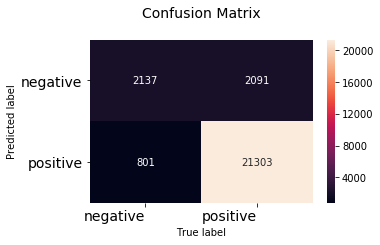

In [421]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_w2v_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

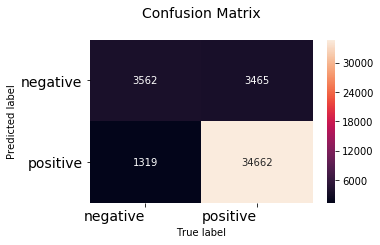

In [422]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_w2v_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

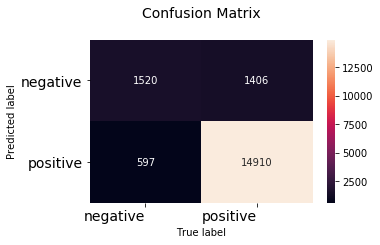

In [423]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_w2v_cv), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

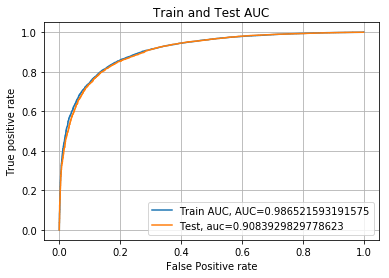

In [424]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_w2v_train[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_w2v_train = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_w2v_test[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_w2v_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_w2v_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_w2v_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [425]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=3)
model.fit(sent_vectors_train, y_tr)
print(model.best_estimator_)
print(model.score(sent_vectors_train, y_tr))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8887183779761905


In [426]:
clf_w2vec_l2=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_w2vec_l2.fit(sent_vectors_train, y_tr)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [427]:
predictions_w2v_test_l2=clf_w2vec_l2.predict(sent_vectors_test)
predictions_w2v_train_l2=clf_w2vec_l2.predict(sent_vectors_train)
predict_w2v_test_l2=clf_w2vec_l2.predict_proba(sent_vectors_test)
predict_w2v_train_l2=clf_w2vec_l2.predict_proba(sent_vectors_train)

predictions_w2v_cv_l2=clf_w2vec_l2.predict(sent_vectors_cv)
predict_w2v_cv_l2=clf_w2vec_l2.predict_proba(sent_vectors_cv)

#### Confusion Matrix Test Data Set

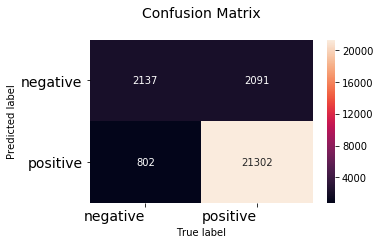

In [428]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_w2v_test_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

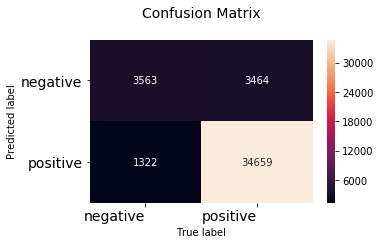

In [429]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_w2v_train_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

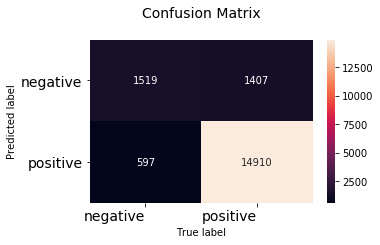

In [430]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_w2v_cv_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

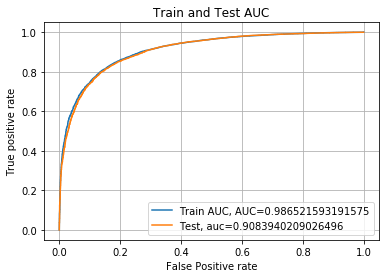

In [431]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_w2v_train_l2[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_w2v_train_l2 = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_w2v_test_l2[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_w2v_test_l2 = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_w2v_train_l2))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_w2v_test_l2))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [432]:
# Please write all the code with proper documentation

In [27]:
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)

In [28]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

Converted Test Train & CV Data to AVG Word to Vec

In [29]:
model = TfidfVectorizer()
tf_idf_matrix_train_w2v = model.fit_transform(X_tr)
tf_idf_matrix_train_w2v = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())  
    

i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())  

In [35]:
from gensim.models import Word2Vec
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8436177372932434), ('awesome', 0.8309186697006226), ('good', 0.8192121982574463), ('excellent', 0.8003607392311096), ('terrific', 0.7851629853248596), ('wonderful', 0.7566136121749878), ('perfect', 0.7445077896118164), ('amazing', 0.6972209811210632), ('fabulous', 0.6968708038330078), ('decent', 0.669394850730896)]
[('greatest', 0.7847853899002075), ('best', 0.7255018353462219), ('tastiest', 0.7070052623748779), ('nastiest', 0.6901845932006836), ('disgusting', 0.6447259187698364), ('smoothest', 0.6248952150344849), ('closest', 0.6245428919792175), ('horrible', 0.6132502555847168), ('hottest', 0.6117188930511475), ('experienced', 0.6018507480621338)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


In [37]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 43008/43008 [08:22<00:00, 85.56it/s] 


In [469]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [04:03<00:00, 108.35it/s]


In [471]:
tfidf_w2v_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 18433/18433 [02:48<00:00, 102.57it/s]


In [457]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()


In [463]:
X_train_tfidf_w2v_std = ssc.fit_transform(tfidf_w2v_sent_vectors_train)
X_test_tfidf_w2v_std = ssc.transform(tfidf_w2v_sent_vectors_test)
X_cv_tfidf_w2v_std = ssc.transform(tfidf_w2v_sent_vectors_cv)


In [459]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=3)
model.fit(tfidf_w2v_sent_vectors_train, y_tr)
print(model.best_estimator_)
print(model.score(tfidf_w2v_sent_vectors_train , y_tr))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.6740141369047619


In [39]:
clf_avg_word_tf=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_avg_word_tf.fit(tfidf_w2v_sent_vectors_train , y_tr)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
#predictions_avgtf_test=clf_avg_word_tf.predict(X_test_tfidf_w2v_std)
predictions_avgtf_train=clf_avg_word_tf.predict(tfidf_w2v_sent_vectors_train)
#predict_avgtf_test=clf_avg_word_tf.predict_proba(X_test_tfidf_w2v_std)
predict_avgtf_train=clf_avg_word_tf.predict_proba(tfidf_w2v_sent_vectors_train)

#predictions_avgtf_cv=clf_avg_word_tf.predict(tfidf_w2v_sent_vectors_cv)
#predict_avgtf_cv=clf_avg_word_tf.predict_proba(tfidf_w2v_sent_vectors_cv)

#### Confusion Matrix Test Data Set

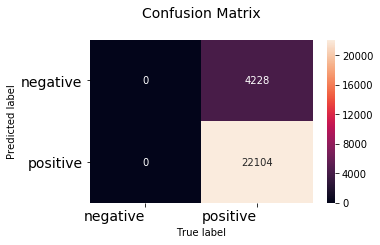

In [474]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_avgtf_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

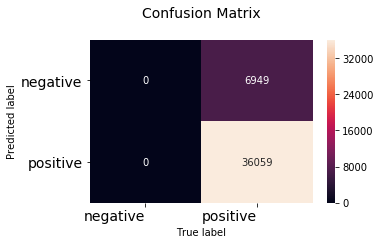

In [41]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_avgtf_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

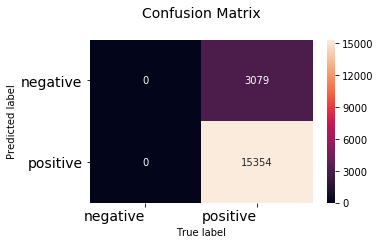

In [496]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_avgtf_cv), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

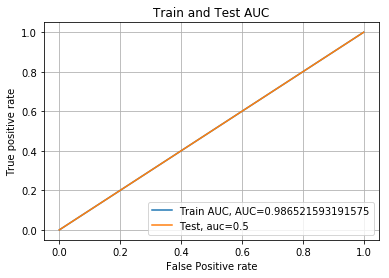

In [445]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_avgtf_train[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_avgtf_train = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_avgtf_test[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_avgtf_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_avgtf_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_avgtf_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [446]:
# Please write all the code with proper documentation

clf_avg_word_tf_l2=LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf_avg_word_tf_l2.fit(tfidf_w2v_sent_vectors_train, y_tr)

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [447]:
predictions_avgtf_test_l2=clf_avg_word_tf_l2.predict(tfidf_w2v_sent_vectors_test)
predictions_avgtf_train_l2=clf_avg_word_tf_l2.predict(tfidf_w2v_sent_vectors_train)
predict_avgtf_test_l2=clf_avg_word_tf_l2.predict_proba(tfidf_w2v_sent_vectors_test)
predict_avgtf_train_l2=clf_avg_word_tf_l2.predict_proba(tfidf_w2v_sent_vectors_train)

predictions_avgtf_cv_l2=clf_avg_word_tf_l2.predict(tfidf_w2v_sent_vectors_cv)
predict_avgtf_cv_l2=clf_avg_word_tf_l2.predict_proba(tfidf_w2v_sent_vectors_cv)

#### Confusion Matrix Test Data Set

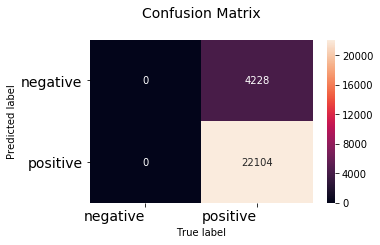

In [489]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_avgtf_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix Train Data Set

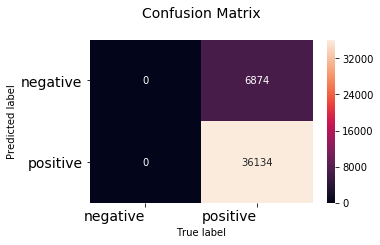

In [449]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_tr, predictions_avgtf_train_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### Confusion Matrix CV  Data Set

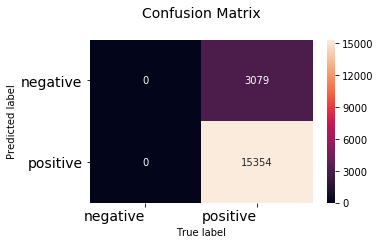

In [450]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_cv, predictions_avgtf_cv_l2), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

#### AUC for Train data & Test Data Set

<function matplotlib.pyplot.show(*args, **kw)>

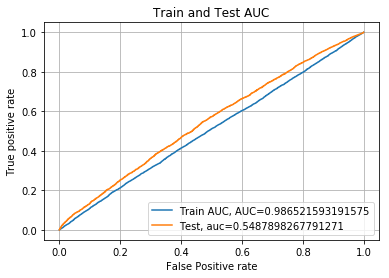

In [451]:
fpr1, tpr1, _ = metrics.roc_curve(y_tr, predict_avgtf_train_l2[:,1])
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc_avgtf_train_l2 = metrics.auc(fpr,tpr)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_avgtf_test_l2[:,1])
df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_avgtf_test_l2= metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_avgtf_train_l2))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_avgtf_test_l2))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

# [6] Conclusions

In [452]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

In [453]:
x = PrettyTable()
x.field_names = ["Model", "AUC Score Train","AUC Score Test" ]

In [454]:
x.add_row(["BOW_L1",auc_bow_train,auc_bow_test] )
x.add_row(["BOW_L2",auc_bow_train_l2, auc_bow_train_l2] )
x.add_row(["TFIDF_L1",auc_tf_train,auc_tf_test] )
x.add_row(["TFIDF_L2",auc_tf_train_l2,auc_tf_test_l2] )
x.add_row(["WORD 2 Vec L1",auc_w2v_train,auc_w2v_test] )
x.add_row(["WORD 2 Vec L2",auc_w2v_train_l2,auc_w2v_test_l2] )
x.add_row(["TFIDF Word to VEC L1",auc_avgtf_train,auc_avgtf_test] )
x.add_row(["TFIDF Word to VEC L2",auc_avgtf_train_l2,auc_avgtf_test_l2] )

In [455]:
print(x)

+----------------------+-------------------+--------------------+
|        Model         |  AUC Score Train  |   AUC Score Test   |
+----------------------+-------------------+--------------------+
|        BOW_L1        | 0.986521593191575 | 0.938523565044371  |
|        BOW_L2        | 0.986521593191575 | 0.986521593191575  |
|       TFIDF_L1       | 0.986521593191575 | 0.9451252910041497 |
|       TFIDF_L2       | 0.986521593191575 | 0.9291735640513874 |
|    WORD 2 Vec L1     | 0.986521593191575 | 0.9083929829778623 |
|    WORD 2 Vec L2     | 0.986521593191575 | 0.9083940209026496 |
| TFIDF Word to VEC L1 | 0.986521593191575 |        0.5         |
| TFIDF Word to VEC L2 | 0.986521593191575 | 0.5487898267791271 |
+----------------------+-------------------+--------------------+


### Conclusion & Steps 

1. Based on the Given Sample Processed Data was used for Analysis
2. Splitting of whole dataset into train_data  test_data and CV
3. Different Types of Vecorizerts applied 
4. Pertubation Testing Applied by addind Error()
5. Top 20 Positive and Negative Features Identified for BOW and TFIDF
6. AUC Score Calcluation for All the vectorizers for Train and Test
7. Comparision of All Models using Pretty Table
8. All Models of Logistic Regression with L1 and L2 Regularization
9. Best Model seems to be BOW with L2 Regularizaion